# Commitment-Driven Reward

The number of agents feeding at any time varies depending on the quality of the reward. In absence of any interactions, the agents which are not feeding at at a given time mave start doing so with a probability proportional to the quality of the resources. Therefore, if the interaction between the agents has any impact on the number of agents currently feeding $n$, then

$$ \frac{dn}{dt} = \alpha R \left( N-n \right) + \beta n \left( N-n \right) $$

where,

- $\alpha$ is the __reward constant__.
- $\beta$ is the __net recruitment constant__.

We assume that these agents are feeding on a common resource whose quality is given by $R$. For each agent which feeds on the resource, the resource quality decreases at a rate $\delta$. Furthermore, let us assume that the resource recovers its quality at a rate proportional to $R_0-r$, where $R_0$ is  the maximum quality that the resource may have. Therefore,

$$ \frac{dR}{dt} = \gamma R \left( R_0 - R \right) - \delta R n  $$

where,

 - $\gamma$ is the __growth rate__.
 - $\delta$ is the __consumption constant__.
 - $R_0$ is the __carrying apacity__.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import odeint
from sympy import *
import ipywidgets as widgets
from IPython.display import display

init_printing()

x, y, α, β, γ, δ, σ = symbols('x y alpha beta gamma delta sigma')
X1, Y1, X2, Y2, X3, Y3, X4, Y4, λ1, λ2, λ3, λ4, Jac = symbols(' x_1 y_1 x_2 y_2 x_3 y_3 x_4 y_4 lambda_1 lambda_2 lambda_3 lambda_4 J')

## The ODE System

$$ \frac{dx}{dt} = \alpha \left( 1-x \right) y + \beta x \left( 1-x \right) $$
$$ \frac{dy}{dt} = \gamma \left( \sigma-y \right) y + \delta x y $$

In [2]:
def do_symbolic_analysis():

    xdot = α*(1-x)*y + β*x*(1-x)
    ydot = γ*y*(σ-y) - δ*x*y

    zdot = Matrix([xdot, ydot])

    z0 = solve(zdot,(x,y))

    J = Matrix([[diff(zdot[0],x), diff(zdot[0],y)],[diff(zdot[1],x), diff(zdot[1],y)]])

    J0 = []
    E0 = []

    for i in range(len(z0)):
        JJ = J.subs([(x,z0[i][0]), (y,z0[i][1])])
        J0.append(JJ)
        EE = Matrix(list(JJ.eigenvals().keys()))
        E0.append(EE)
        
        z0[i] = Matrix(z0[i])
        
    r = {
        'dyn_eq': zdot,
        'fixed_points': z0,
        'jacobian': J,
        'jacobian_at_fixed_points': J0,
        'eigenvalues_at_fixed_points': E0
    }
    
    return r

s = do_symbolic_analysis()

### Jacobian

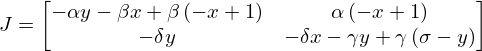

In [3]:
display(Eq(Jac,s['jacobian'],evaluate=False))

### Fixed Points

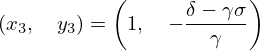

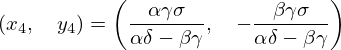

In [4]:
display(Eq((X1,Y1),tuple(s['fixed_points'][0]),evaluate=False))
display(Eq((X2,Y2),tuple(s['fixed_points'][1]),evaluate=False))
display(Eq((X3,Y3),tuple(s['fixed_points'][2]),evaluate=False))
display(Eq((X4,Y4),tuple(s['fixed_points'][3]),evaluate=False))

### Eigenvalues at the Fixed Points

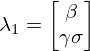

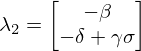

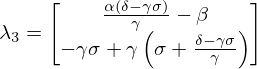

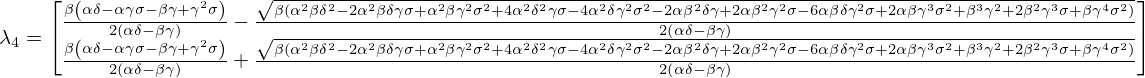

In [5]:
display(Eq(λ1,s['eigenvalues_at_fixed_points'][0],evaluate=False))
print()
display(Eq(λ2,s['eigenvalues_at_fixed_points'][1],evaluate=False))
print()
display(Eq(λ3,s['eigenvalues_at_fixed_points'][2],evaluate=False))
print()
display(Eq(λ4,s['eigenvalues_at_fixed_points'][3],evaluate=False))

## The Numerical Simulations

We also perform numerical simulations to better visualize the system.

In [6]:
def ode_sys(zz, t, α, β, γ, δ, σ):
    
    xx = α*(1-zz[0])*zz[1] + β*zz[0]*(1-zz[0])
    yy = γ*zz[1]*(σ-zz[1]) - δ*zz[0]*zz[1]
    
    return [xx,yy]

### Default System Parameters

- α = 0.1
- β = -0.03
- γ = 0.03 
- δ = 0.025 
- σ = 1.0 

In [7]:
def set_system_parameters(α=0.1, β=-0.03, γ=0.03, δ=0.025, σ=1.0):
    return { 'α': α, 'β': β, 'γ': γ, 'δ': δ, 'σ': σ }
sys_p = set_system_parameters()

### Default Integration Parameters

- Total time = 1000
- Steps length = 1
- Initial Conditions = (0.0, 0.1)

In [8]:
def set_integration_parameters(tf=1000, dt=1.0, x0=0.0, y0=0.1):
    return { 'tf': tf, 'dt': dt, 'x0': x0, 'y0': y0 }
int_p = set_integration_parameters(tf=1000)

Using these parameters, we numerically simulate the system.

In [9]:
def numeric_simulation(sys_params, int_params):
    t = np.arange(0, int_params['tf'], int_params['dt'])
    z0 = [int_params['x0'], int_params['y0']]
    p = (sys_params['α'], sys_params['β'], sys_params['γ'], sys_params['δ'], sys_params['σ'])
    sol = odeint(ode_sys, z0, t, args = p)
    return(t, sol)
t, sol = numeric_simulation(sys_p, int_p)

We next match the numerical results with the analytics by substituting the parameters into the results.

In [10]:
def substitute_parameters(s, sys_p):
    
    substitutions = [(α, sys_p['α']), (β, sys_p['β']), (γ, sys_p['γ']), (δ, sys_p['δ']), (σ, sys_p['σ'])]
    
    r = {}
    r['dyn_eq'] = s['dyn_eq'].subs(substitutions)
    r['jacobian'] = s['jacobian'].subs(substitutions)

    r['fixed_points'] = s['fixed_points']
    r['jacobian_at_fixed_points'] = s['jacobian_at_fixed_points']
    r['eigenvalues_at_fixed_points'] = s['eigenvalues_at_fixed_points']
    
    for i in range(len(s['fixed_points'])):
        r['fixed_points'][i] = s['fixed_points'][i].subs(substitutions)
        r['jacobian_at_fixed_points'][i] = s['jacobian_at_fixed_points'][i].subs(substitutions)
        r['eigenvalues_at_fixed_points'][i] = s['eigenvalues_at_fixed_points'][i].subs(substitutions)
        
    return r
s0 = substitute_parameters(s,sys_p)

## The Results

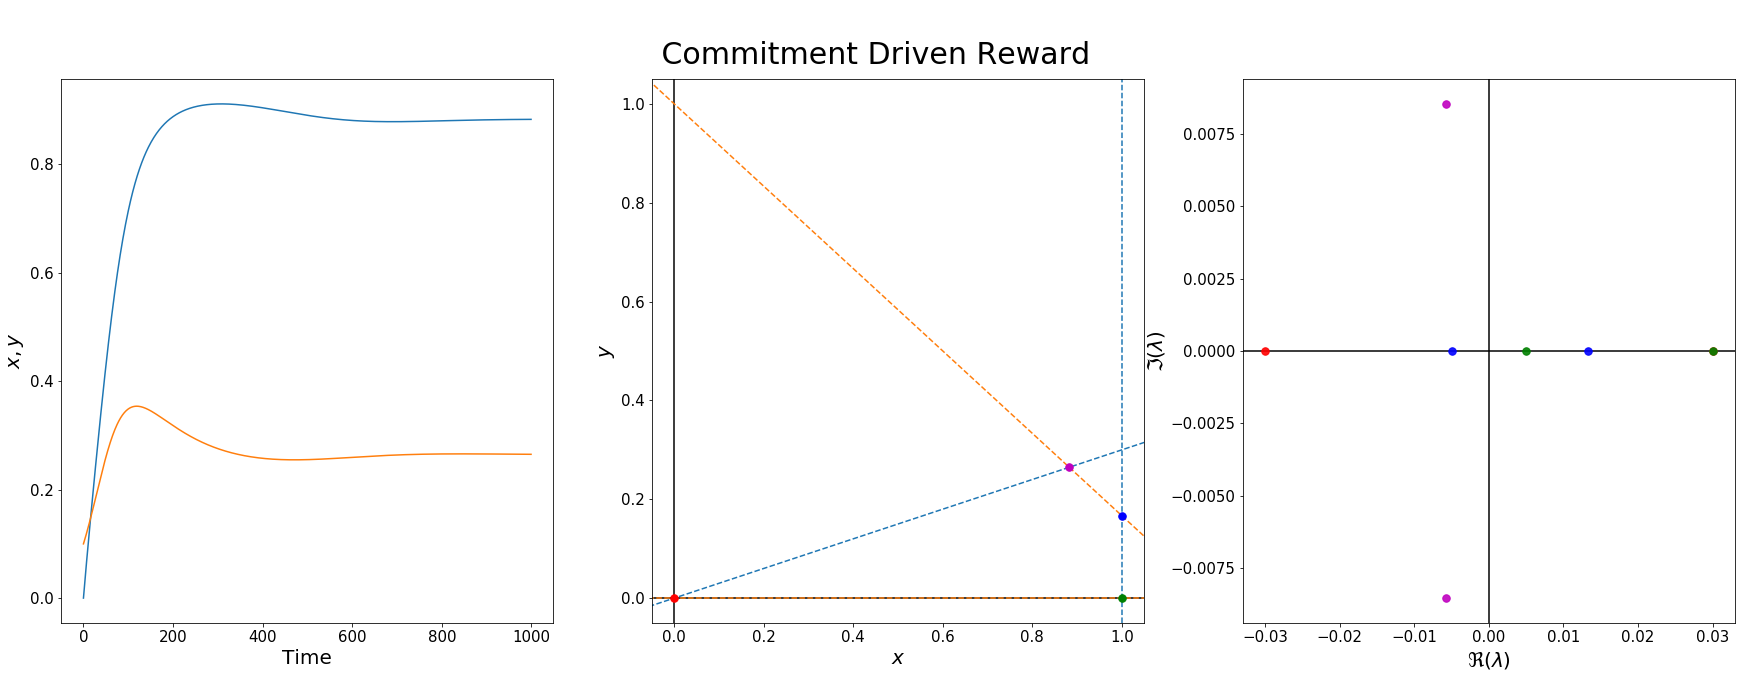

In [11]:
def plotter(t, sol, s0):
    
    fig, ax = plt.subplots(1,3, figsize=(30,10))
    fig.suptitle('\n Commitment Driven Reward', fontsize=30)

    for i in range(len(ax)):
        ax[i].tick_params(axis='both', which='major', labelsize=15)
        
    ax[0].set_xlabel('Time', fontsize=20)
    ax[1].set_xlabel('$x$', fontsize=20)
    ax[2].set_xlabel('$\Re(\lambda)$', fontsize=20)
    
    ax[0].set_ylabel('$x, y$', fontsize=20)
    ax[1].set_ylabel('$y$', fontsize=20)
    ax[2].set_ylabel('$\Im(\lambda)$', fontsize=20)
    
    ax[0].plot(t,sol[:,0])
    ax[0].plot(t,sol[:,1])
    
    ax[1].axhline(0, color='k')
    ax[1].axvline(0, color='k')

    xx = solve(s0['dyn_eq'][0],y)
    yy = solve(s0['dyn_eq'][1],y)

    xs = np.arange(-1,2,0.01)
    y1 = np.zeros(len(xs))
    y2 = np.zeros(len(xs))
    y3 = np.zeros(len(xs))

    for i in range(len(xs)):
        y1[i] = xx[0].subs(x,xs[i])
        y2[i] = yy[0].subs(x,xs[i])
        y3[i] = yy[1].subs(x,xs[i])
        
    ax[1].plot(xs,y1,'C0',ls='--')
    ax[1].axvline(1,color='C0',ls='--')
    ax[1].plot(xs,y2,'C1',ls='--')
    ax[1].plot(xs,y3,'C1',ls='--')
    
    colors = ['r', 'g', 'b', 'm']
    for i in range(len(s0['fixed_points'])):
        ax[1].plot(s0['fixed_points'][i][0],s0['fixed_points'][i][1],'.',ms=15, color=colors[i])

    ax[1].set_xlim((-0.05,1.05))
    ax[1].set_ylim((-0.05,1.05))

    ax[2].axhline(0, color='k')
    ax[2].axvline(0, color='k')

    for i in range(len(s0['fixed_points'])):
        b = complex(s0['eigenvalues_at_fixed_points'][i][0])
        ax[2].plot(b.real, b.imag,'.',ms=15, color=colors[i],alpha=0.9)
        b = complex(s0['eigenvalues_at_fixed_points'][i][1])
        ax[2].plot(b.real, b.imag,'.',ms=15, color=colors[i],alpha=0.9)
        
    plt.show()

%matplotlib inline
plotter(t,sol,s0)